For the analysis in Appendix E, change `START_DATE_FILTER = '2022-11-01'` to `START_DATE_FILTER = None` in data_loader.py before running this.

# Setup

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
# Analysis parameters
CUTOFF_DATE = '2024-09-01'  # Date for validation split
FORECAST_YEARS = 3  # Number of years to forecast ahead
TOP_N_MODELS = 1  # Number of top models at release to use for frontier (1 = pure frontier)
LABEL_FRONTIER = False  # Whether to annotate frontier model names on plots

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


def _logistic(x: np.ndarray) -> np.ndarray:
    x_clipped = np.clip(x, -500, 500)
    return 1.0 / (1.0 + np.exp(-x_clipped))


def plot_benchmark_forecast(
    benchmark_name: str,
    forecast_results: dict,
    df_cm: pd.DataFrame,
    df_db: pd.DataFrame,
    *,
    show_prediction_interval: bool = True,
    show_confidence_interval: bool = False,
    history_source_df: pd.DataFrame | None = None,
    title: str | None = None,
):
    """
    Plot historical and forecasted benchmark scores based on capability projections.

    Parameters
    - benchmark_name: exact name in df_db['benchmark_name'] and data_loader.scores_df['benchmark']
    - forecast_results: output dict from create_future_forecast(...) or create_post_cutoff_frontier_forecast(...)
        expected keys: 'forecast_df' with columns ['date','predicted_capability','ci_lower','ci_upper','pi_lower','pi_upper']
    - df_cm: model capabilities dataframe (e.g., df_cm1) with columns ['model','date','date_obj','estimated_capability']
    - df_db: benchmark params dataframe (e.g., df_db1) with columns ['benchmark_name','estimated_difficulty','estimated_slope']
    - history_source_df: optional raw scores dataframe to plot historical scores; if None tries to infer from earlier cells
    - show_prediction_interval/confidence_interval: overlay intervals from forecast_results if present
    - title: optional custom title
    """
    if forecast_results is None or len(forecast_results) == 0:
        raise ValueError("forecast_results is empty; run capability forecast first.")

    forecast_df = forecast_results.get("forecast_df")
    if forecast_df is None or forecast_df.empty:
        raise ValueError("forecast_results['forecast_df'] is missing or empty.")

    # Look up benchmark difficulty and slope
    bench_row = df_db.loc[df_db["benchmark_name"] == benchmark_name]
    if bench_row.empty:
        raise ValueError(f"Benchmark '{benchmark_name}' not found in df_db['benchmark_name'].")

    D_b = bench_row.iloc[0]["estimated_difficulty"]
    alpha_b = bench_row.iloc[0]["estimated_slope"]

    # Convert capability forecast to expected score via logistic(alpha_b * (C - D_b))
    C_hat = forecast_df["predicted_capability"].values
    score_forecast = _logistic(alpha_b * (C_hat - D_b))

    # Optional intervals propagated in capability space -> map endpoints through logistic
    ci_lower = forecast_df["ci_lower"].values if "ci_lower" in forecast_df.columns else None
    ci_upper = forecast_df["ci_upper"].values if "ci_upper" in forecast_df.columns else None
    pi_lower = forecast_df["pi_lower"].values if "pi_lower" in forecast_df.columns else None
    pi_upper = forecast_df["pi_upper"].values if "pi_upper" in forecast_df.columns else None

    score_ci_lower = _logistic(alpha_b * (ci_lower - D_b)) if ci_lower is not None and show_confidence_interval else None
    score_ci_upper = _logistic(alpha_b * (ci_upper - D_b)) if ci_upper is not None and show_confidence_interval else None
    score_pi_lower = _logistic(alpha_b * (pi_lower - D_b)) if pi_lower is not None and show_prediction_interval else None
    score_pi_upper = _logistic(alpha_b * (pi_upper - D_b)) if pi_upper is not None and show_prediction_interval else None

    # Historical points: take top/frontier capability per date, convert to score for this benchmark
    df_cap = df_cm.dropna(subset=["date_obj","estimated_capability"]).copy()
    df_cap.sort_values("date_obj", inplace=True)

    # Using all models per date: choose the max capability observed up to that date as proxy frontier
    df_cap["cum_max_capability"] = df_cap["estimated_capability"].cummax()
    hist_dates = df_cap["date_obj"].values
    hist_scores = _logistic(alpha_b * (df_cap["cum_max_capability"].values - D_b))

    # Raw benchmark history (optional): plot actual observed scores if provided
    hist_bench_dates = None
    hist_bench_scores = None
    if history_source_df is not None and "benchmark" in history_source_df.columns:
        df_hist = history_source_df[history_source_df["benchmark"] == benchmark_name].copy()
        if not df_hist.empty and "date" in df_hist.columns and "performance" in df_hist.columns:
            df_hist["date"] = pd.to_datetime(df_hist["date"], errors="coerce")
            df_hist = df_hist.dropna(subset=["date","performance"]).sort_values("date")
            hist_bench_dates = df_hist["date"].values
            hist_bench_scores = df_hist["performance"].values

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))

    # Historical implied scores from frontier capability
    ax.plot(hist_dates, hist_scores, color="#666", linewidth=1.5, label="Implied (frontier) score")

    # Actual observed historical scores if available
    if hist_bench_dates is not None:
        ax.scatter(hist_bench_dates, hist_bench_scores, s=16, alpha=0.7, color="#1f77b4", label="Observed scores")

    # Forecasted scores
    ax.plot(forecast_df["date"].values, score_forecast, color="red", linewidth=2.0, label="Forecast (score)")

    # Intervals
    if score_ci_lower is not None and score_ci_upper is not None:
        ax.fill_between(
            forecast_df["date"].values,
            score_ci_lower,
            score_ci_upper,
            color="red",
            alpha=0.25,
            label="95% CI (score)"
        )
    if score_pi_lower is not None and score_pi_upper is not None:
        ax.fill_between(
            forecast_df["date"].values,
            score_pi_lower,
            score_pi_upper,
            color="red",
            alpha=0.15,
            label="95% PI (score)"
        )

    ax.set_ylim(0, 1)
    ax.set_ylabel("Benchmark score (0–1)")
    ax.set_xlabel("Date")
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f"Forecasted scores for '{benchmark_name}'")
    ax.legend(loc="lower right")
    ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.6)

    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    fig.autofmt_xdate()
    plt.savefig(f"outputs/notebooks/benchmark_forecast_{benchmark_name.replace('/', '_').replace(' ', '_')}.pdf", dpi=300, bbox_inches='tight')
    plt.show()

    # Return a convenient DataFrame with the score forecast
    out = forecast_df.copy()
    out["forecasted_score"] = score_forecast
    if score_ci_lower is not None:
        out["score_ci_lower"] = score_ci_lower
        out["score_ci_upper"] = score_ci_upper
    if score_pi_lower is not None:
        out["score_pi_lower"] = score_pi_lower
        out["score_pi_upper"] = score_pi_upper
    return out


In [4]:

import seaborn as sns
sns.set()
sns.set_style("whitegrid")

# Custom color palette
custom_colors = [
    '#00A5A6',  # teal
    '#E03D90',  # pink
    '#FC6538',  # orange
    '#6A3ECB',  # purple
    '#0058DC',  # blue
    '#EA8D00',  # yellow
    '#B087F4',  # lightPurple
    '#279E27',  # green
    '#009AF1',  # lightBlue
    '#015D90',  # darkBlue
    '#EA4831',  # red
    '#E1C700',  # yellow2
    '#46FFFF',  # turquoise
    '#63F039',  # lightGreen
]

sns.set_palette(custom_colors)
colors = sns.color_palette()

# === Seaborn global settings ===
sns.set_theme(
    style="whitegrid",        # or "darkgrid", "ticks", "white"
    palette=custom_colors,    # your custom color palette
    context="notebook"        # scaling for labels/titles ("paper", "notebook", "talk", "poster")
)

# === Matplotlib global settings (rcParams) ===
plt.rcParams.update({
    # Figure
    "figure.figsize": (8, 5),
    "figure.dpi": 120,
    
    # Axes
    "axes.titley": 1.02,
    "axes.titlesize": 14,
    "axes.titlelocation": 'center',
    "axes.titlepad": 0,
    "axes.labelsize": 12,
    "axes.labelpad": 10,           # spacing between axis and label
    "axes.spines.top": False,
    "axes.spines.right": False,
    
    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    # tick marks size
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    
    # tick visibility
    "xtick.top": False,
    "xtick.bottom": True,
    "ytick.left": True,
    "ytick.right": False,
    
    # Legend
    "legend.fontsize": 10,
    "legend.loc": "upper left",
    "legend.frameon": True,
    "legend.borderaxespad": 0,

    
    # Lines and markers
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "lines.markeredgecolor": 'auto',   # white outline (stroke)
    "lines.markeredgewidth": 0.5,   
    # title alignment left
    

    
    
    # Error bars
    "errorbar.capsize": 3,
    
    # Font
    "font.family": "Arial",
    "font.sans-serif": ["DejaVu Sans"],
    
    # Grid
    "grid.alpha": 0.3,
    "grid.linestyle": "-",
    "grid.color": "lightgray",
})


In [5]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.dates import DateFormatter
# from sklearn.linear_model import LinearRegression


# def _safe_logit(p: np.ndarray) -> np.ndarray:
#     p = np.clip(p, 1e-6, 1 - 1e-6)
#     return np.log(p / (1 - p))

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model
from sklearn.linear_model import LinearRegression

null performances after coercion: 0
after filter num benchmarks 1965
after merge with model versions 1965
after date filter (>= 2022-11-01) 1766
after merge with benchmark dates 1766
Original number of rows: 1766
Number of rows after aggregation: 1324


In [7]:
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
df1, df_cm1, df_db1 = fit_statistical_model(scores_df, anchor_benchmark=anchor_benchmark, anchor_difficulty=anchor_difficulty, anchor_slope=anchor_slope)

# Convert date strings to datetime objects
df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

`ftol` termination condition is satisfied.
Function evaluations 29, initial cost 5.0131e+01, final cost 3.4474e+00, first-order optimality 3.21e-04.


In [8]:
# keep only models released before cutoff
cutoff_date = "2024-07-01"
cutoff_date = pd.to_datetime(cutoff_date)
scores_df['date'] = pd.to_datetime(scores_df['date'], errors='coerce')
scores_df_cut = scores_df[scores_df['date'] < cutoff_date]
scores_df_cut = scores_df_cut[scores_df_cut['benchmark_release_date'] < cutoff_date]
dropped_models = set(scores_df['model']) - set(scores_df_cut['model'].unique())
print(f"Models dropped by date filter: {len(dropped_models)} →", dropped_models)
dropped_benchmarks = set(scores_df['benchmark']) - set(scores_df_cut['benchmark'].unique())
print(f"Benchmarks dropped by date filter: {len(dropped_benchmarks)} →", dropped_benchmarks)

anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
df2, df_cm2, df_db2 = fit_statistical_model(scores_df_cut, anchor_benchmark=anchor_benchmark, anchor_difficulty=anchor_difficulty, anchor_slope=anchor_slope)

Models dropped by date filter: 100 → {'gpt-4.5-preview-2025-02-27', 'claude-3-7-sonnet-20250219', 'grok-4-fast', 'Llama-3.1-8B-Instruct', 'gemini-2.0-flash-001', 'mistral-small-2501', 'claude-opus-4-20250514', 'DeepSeek-V3', 'gpt-4.1-mini-2025-04-14', 'DeepSeek-V3.1', 'qwen-max-2025-01-25', 'claude-3-5-haiku-20241022', 'gpt-5-2025-08-07_medium', 'claude-opus-4-1-20250805', 'grok-3-mini-beta_low', 'claude-sonnet-4-20250514_32K', 'o1-2024-12-17_medium', 'claude-3-5-sonnet-20241022', 'claude-opus-4-1-20250805_16K', 'mistral-medium-2505', 'gpt-4.1-2025-04-14', 'claude-3-7-sonnet-20250219_16K', 'qwen3-max-2025-09-23', 'Llama-4-Maverick-17B-128E-Instruct-FP8', 'gemini-2.0-pro-exp-02-05', 'claude-sonnet-4-5-20250929', 'o4-mini-2025-04-16_high', 'mistral-small-2503', 'Qwen2.5-Coder-32B', 'claude-3-7-sonnet-20250219_32K', 'o1-mini-2024-09-12_high', 'Qwen2.5-72B', 'gemini-2.5-pro-exp-03-25', 'claude-opus-4-1-20250805_27K', 'gpt-5-2025-08-07_high', 'o3-mini-2025-01-31_medium', 'gemini-2.0-flash-e

In [9]:
for i in [df1, df2, df_cm1, df_cm2, df_db1, df_db2]:
  print(len(i))

1324
493
179
79
38
17


In [10]:
from pathlib import Path
from datetime import timedelta
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# Define helper functions inline (to avoid import issues)
def prepare_model_data(df_capabilities: pd.DataFrame) -> pd.DataFrame:
    """Prepare model capabilities data with datetime conversion"""
    df = df_capabilities.copy()
    df['date_obj'] = pd.to_datetime(df['date'])
    return df.sort_values('date_obj')

def filter_by_date(df: pd.DataFrame, 
                  date_col: str, 
                  cutoff_date: str,
                  before: bool = True) -> pd.DataFrame:
    """Filter dataframe by date"""
    cutoff = pd.to_datetime(cutoff_date)
    if before:
        return df[df[date_col] <= cutoff].copy()
    else:
        return df[df[date_col] > cutoff].copy()

def bootstrap_slope_analysis(df: pd.DataFrame, 
                           x_col: str, 
                           y_col: str, 
                           n_bootstrap: int = 10000) -> dict:
    """Perform bootstrap analysis to estimate slope with confidence intervals"""
    # Convert dates to numeric if needed
    if df[x_col].dtype == 'datetime64[ns]':
        x_numeric = (df[x_col] - df[x_col].min()).dt.days
    else:
        x_numeric = df[x_col]
    
    # Bootstrap sampling
    slopes = []
    for _ in range(n_bootstrap):
        sample_idx = np.random.choice(len(df), size=len(df), replace=True)
        x_sample = x_numeric.iloc[sample_idx].values.reshape(-1, 1)
        y_sample = df[y_col].iloc[sample_idx].values
        
        model = LinearRegression()
        model.fit(x_sample, y_sample)
        
        # Convert slope to per-year if using days
        slope = model.coef_[0]
        if df[x_col].dtype == 'datetime64[ns]':
            slope *= 365.25  # Convert from per-day to per-year
            
        slopes.append(slope)
    
    slopes = np.array(slopes)
    
    return {
        'mean_slope': np.mean(slopes),
        'std_slope': np.std(slopes),
        'ci_2_5': np.percentile(slopes, 2.5),
        'ci_97_5': np.percentile(slopes, 97.5)
    }


# Growth rate (Section 3.2: Trends)

Annual growth rate: 0.5588
95% CI for slope: [0.4478, 0.6698]
R^2: 0.9068


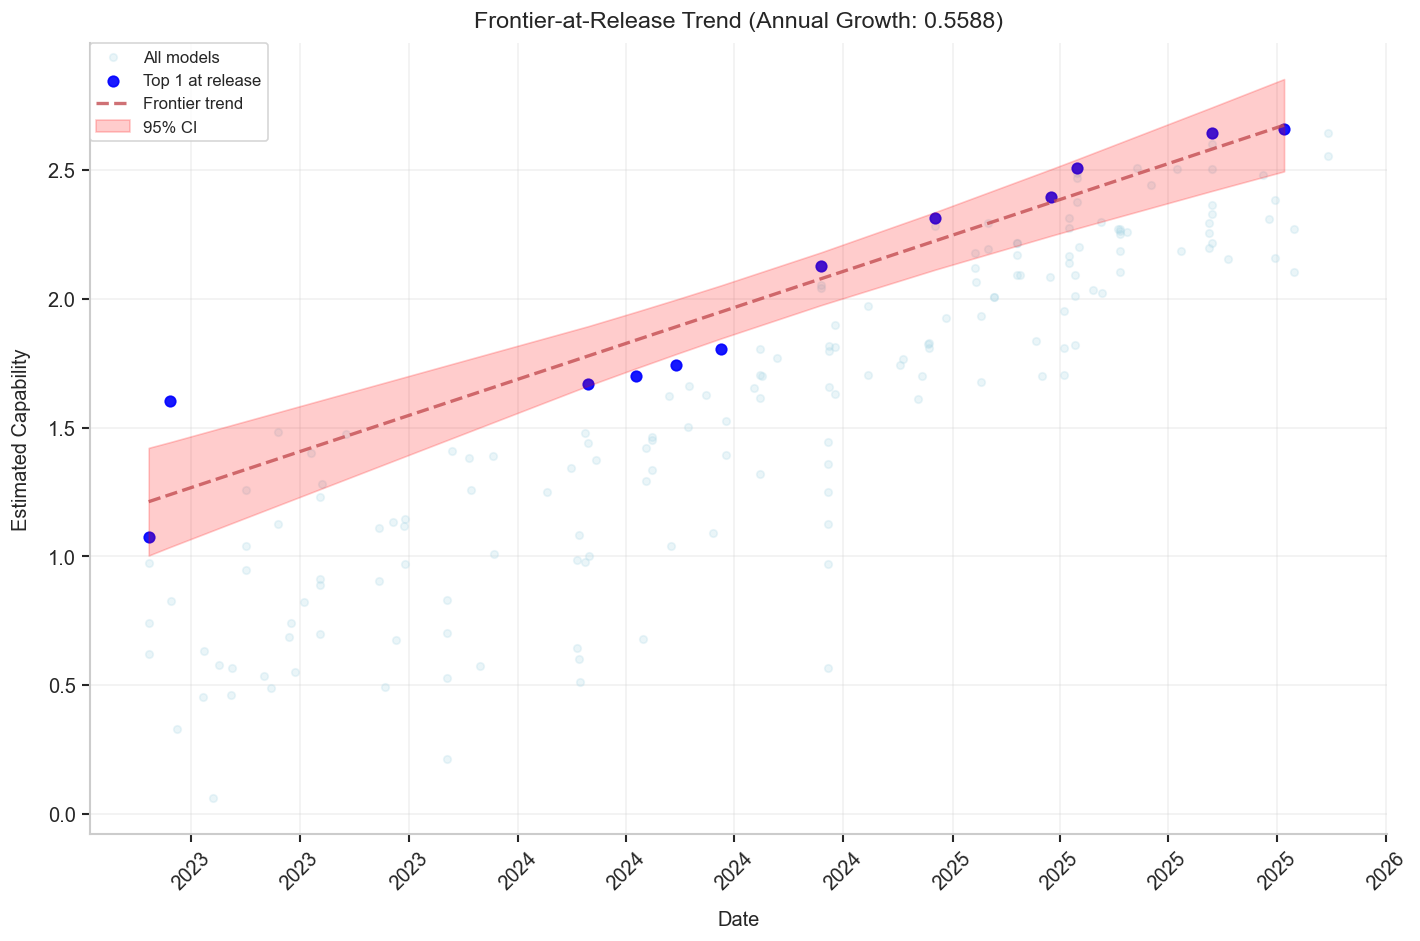

In [11]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

# Identify models that were SOTA (top-N) at their release and fit a trend
TOP_N_AT_RELEASE = 1  # change to >1 if you want top-N frontier, not strict SOTA

# Prepare data
df_all = df_cm1.copy()
# Ensure datetime
if "date_obj" not in df_all.columns or not np.issubdtype(
    df_all["date_obj"].dtype, np.datetime64
):
    df_all["date_obj"] = pd.to_datetime(df_all["date"])

df_all = (
    df_all.dropna(subset=["date_obj", "estimated_capability"])
    .sort_values("date_obj")
    .reset_index(drop=True)
)

# Compute frontier-at-release
frontier_rows = []
for _, row in df_all.iterrows():
    release_date = row["date_obj"]
    available = df_all[df_all["date_obj"] <= release_date]
    top_at_release = available.nlargest(TOP_N_AT_RELEASE, "estimated_capability")
    if row["model"] in top_at_release["model"].values:
        frontier_rows.append(row)

df_frontier = pd.DataFrame(frontier_rows).sort_values("date_obj").reset_index(drop=True)

# Fit linear trend through frontier points
if len(df_frontier) >= 2:
    X = (
        df_frontier["date_obj"] - df_frontier["date_obj"].min()
    ).dt.days.values.reshape(-1, 1)
    y = df_frontier["estimated_capability"].values
    lr = LinearRegression()
    lr.fit(X, y)
    slope_per_year = lr.coef_[0] * 365.25
    r2 = lr.score(X, y)

    # statsmodels for confidence intervals
    X_sm = sm.add_constant(X.flatten())
    model_sm = sm.OLS(y, X_sm).fit()
    predictions = model_sm.get_prediction(X_sm)
    ci_lower = predictions.conf_int()[:, 0]
    ci_upper = predictions.conf_int()[:, 1]

    # Print with CI
    print(f"Annual growth rate: {slope_per_year:.4f}")
    print(
        f"95% CI for slope: [{model_sm.params[1]*365.25 - 1.96*model_sm.bse[1]*365.25:.4f}, "
        f"{model_sm.params[1]*365.25 + 1.96*model_sm.bse[1]*365.25:.4f}]"
    )
    print(f"R^2: {r2:.4f}")

    # Plot with confidence bands
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(
        df_all["date_obj"],
        df_all["estimated_capability"],
        alpha=0.25,
        s=20,
        label="All models",
        color="lightblue",
    )
    ax.scatter(
        df_frontier["date_obj"],
        df_frontier["estimated_capability"],
        alpha=0.9,
        s=40,
        label=f"Top {TOP_N_AT_RELEASE} at release",
        color="blue",
    )
    ax.plot(
        df_frontier["date_obj"], lr.predict(X), "r--", alpha=0.8, label="Frontier trend"
    )

    # Add confidence band
    ax.fill_between(
        df_frontier["date_obj"],
        ci_lower,
        ci_upper,
        alpha=0.2,
        color="red",
        label="95% CI",
    )

    ax.set_xlabel("Date")
    ax.set_ylabel("Estimated Capability")
    ax.set_title(f"Frontier-at-Release Trend (Annual Growth: {slope_per_year:.4f})")
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(
        "outputs/forecasting/frontier_at_release_trend.pdf",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

else:
    lr = None
    slope_per_year = np.nan
    r2 = np.nan

# Table 1: Example estimated model capabilities for notable models (Section 3.2.1 Forecasting future capabilities)

In [12]:
ref_models = [
    "claude-2.0",
    "claude-3-opus-20240229",
    "claude-3-7-sonnet-20250219_64K",
    "claude-3-5-sonnet-20241022",
    "claude-3-5-sonnet-20240620",
    "claude-opus-4-20250514_16K",
    "o1-2024-12-17_high",
    "o1-mini-2024-09-12_high",
    "o3-2025-04-16_high",
    "o3-mini-2025-01-31_high",
    "o4-mini-2025-04-16_high",
    "text-davinci-001",
    "gpt-4-0314",
    "gpt-4-0613",
    "gpt-4o-2024-11-20",
    "gpt-4o-mini-2024-07-18",
    "gpt-4.5-preview-2025-02-27",
    "gpt-5-2025-08-07_high",
    "claude-sonnet-4-5-20250929",
    "claude-opus-4-20250514_32K",
    "claude-opus-4-1-20250805_32K",
    "grok-4-0709",
    "text-davinci-003",
    "text-davinci-002",
    "text-davinci-001",
    "davinci-002",
    "davinci",
    "gpt2-xl",
]

df_cm1[df_cm1["model"].isin(ref_models)][["model", "estimated_capability"]]

,model,estimated_capability
135,gpt-5-2025-08-07_high,2.645294
107,o3-2025-04-16_high,2.509142
4,grok-4-0709,2.505004
106,o4-mini-2025-04-16_high,2.467840
131,o3-mini-2025-01-31_high,2.294050
129,o1-2024-12-17_high,2.284459
100,claude-opus-4-20250514_16K,2.262734
95,claude-3-7-sonnet-20250219_64K,2.215722
22,claude-sonnet-4-5-20250929,2.156811
130,o1-mini-2024-09-12_high,2.126120


# Figure 5: 3-year forecast (Section 3.2.1 Forecasting future capabilities)

Creating 3-year capability forecast using models that were top 1 at release...
Using 12 frontier model data points (from 179 total)
Frontier models: LLaMA-65B, gpt-4-0314, claude-3-opus-20240229, gpt-4-turbo-2024-04-09, gpt-4o-2024-05-13, claude-3-5-sonnet-20240620, o1-mini-2024-09-12_high, o1-2024-12-17_medium, gemini-2.5-pro-exp-03-25, o3-2025-04-16_high

Frontier Forecast (3 years, models that were top 1 at release):
  Annual growth rate: 0.559
  Model R²: 0.907

Forecast table:


,date,predicted_capability,ci_lower,ci_upper,pi_lower,pi_upper
0,2025-11-30,2.757255,2.562271,2.952240,2.562271,2.952240
1,2025-12-31,2.804684,2.600489,3.008879,2.600489,3.008879
2,2026-01-31,2.852112,2.638567,3.065657,2.638567,3.065657
3,2026-02-28,2.894951,2.672854,3.117047,2.672854,3.117047
4,2026-03-31,2.942379,2.710712,3.174046,2.710712,3.174046
5,2026-04-30,2.988277,2.747257,3.229298,2.747257,3.229298
6,2026-05-31,3.035706,2.784937,3.286475,2.784937,3.286475
7,2026-06-30,3.081604,2.821330,3.341879,2.821330,3.341879
8,2026-07-31,3.129033,2.858869,3.399197,2.858869,3.399197
9,2026-08-31,3.176461,2.896347,3.456575,2.896347,3.456575


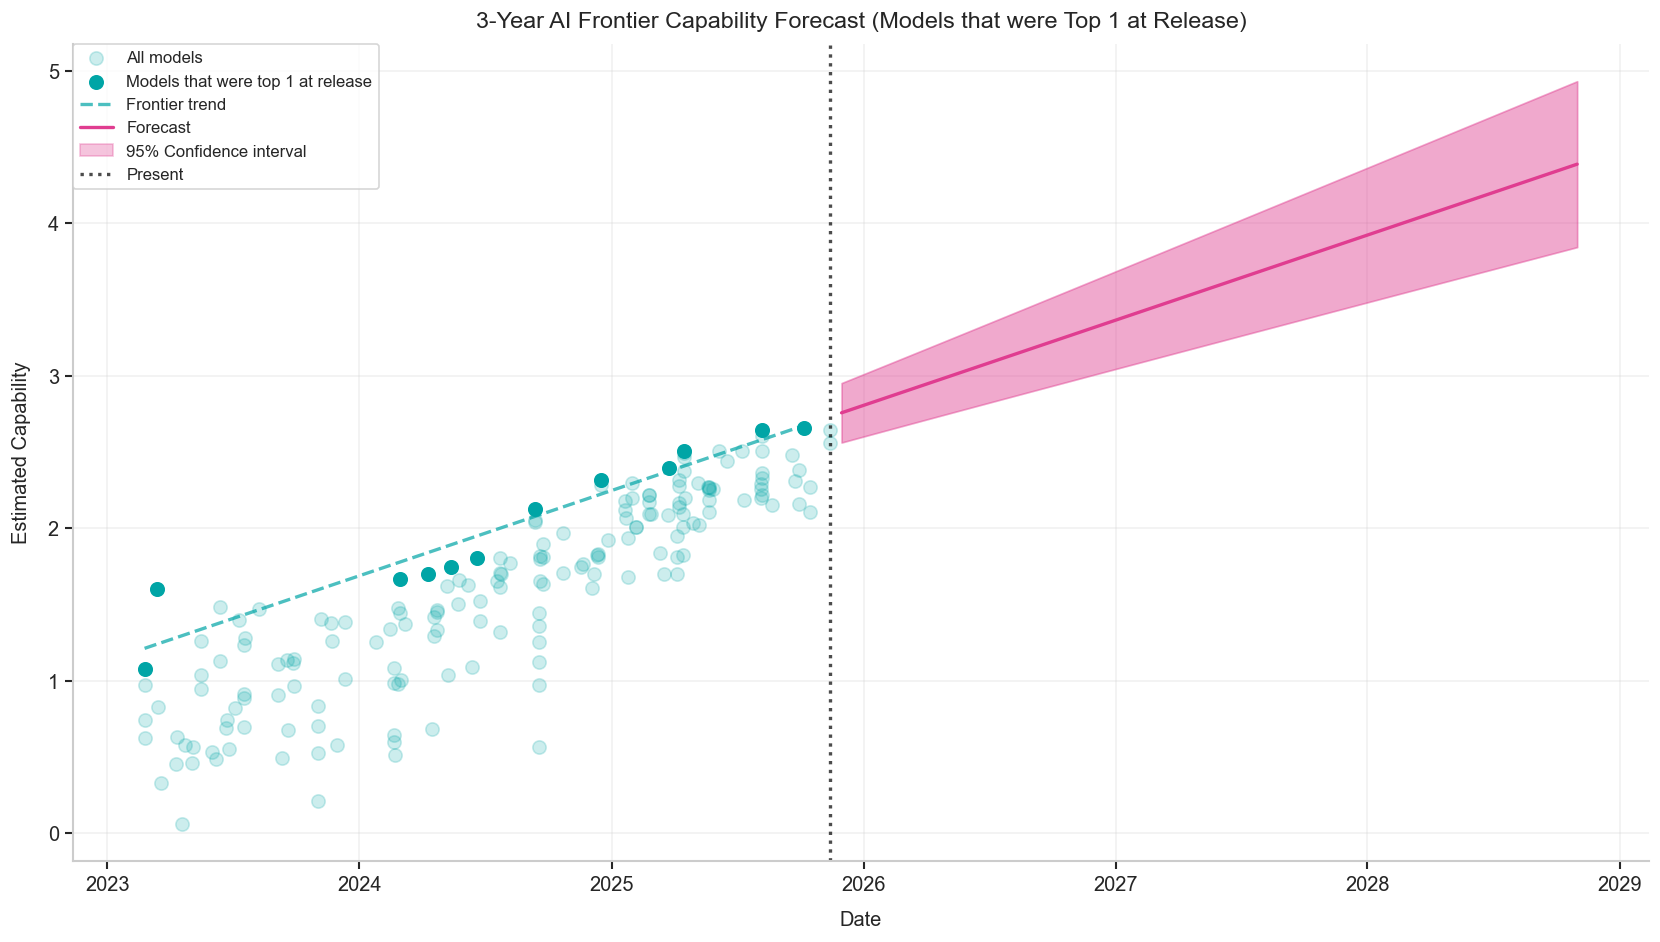

In [13]:
def create_future_forecast(df_capabilities: pd.DataFrame,
                         forecast_years: int = 3,
                         top_n_models: int = 1,
                         label_frontier: bool = False):
    """Create forecast for future capabilities based on models that were frontier at release"""
    print(f"Creating {forecast_years}-year capability forecast using models that were top {top_n_models} at release...")
    
    df = prepare_model_data(df_capabilities)
    
    # Identify frontier models: those that were among top N when they were released
    frontier_models = []
    
    for _, model in df.iterrows():
        model_release_date = model['date_obj']
        model_capability = model['estimated_capability']
        
        # Find all models that existed at or before this model's release date
        available_models = df[df['date_obj'] <= model_release_date]
        
        # Check if this model was among the top N at its release time
        top_models_at_release = available_models.nlargest(top_n_models, 'estimated_capability')
        
        if model['model'] in top_models_at_release['model'].values:
            frontier_models.append(model)
    
    # Convert to DataFrame
    df_frontier = pd.DataFrame(frontier_models)
    
    print(f"Using {len(df_frontier)} frontier model data points (from {len(df)} total)")
    print(f"Frontier models: {', '.join(df_frontier.nsmallest(10, 'date_obj')['model'].tolist())}")
    
    # Prepare data for modeling using only frontier models
    X = (df_frontier['date_obj'] - df_frontier['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y = df_frontier['estimated_capability'].values
    
    # Fit linear model
    model = LinearRegression()
    model.fit(X, y)
    
    # Also fit with statsmodels for confidence intervals
    X_sm = sm.add_constant(X.flatten())
    model_sm = sm.OLS(y, X_sm).fit()
    
    # Create forecast dates
    last_date = df['date_obj'].max()
    forecast_end = last_date + timedelta(days=365.25 * forecast_years)
    forecast_dates = pd.date_range(start=last_date, end=forecast_end, freq='ME')
    
    # Convert forecast dates to numeric
    X_forecast = (forecast_dates - df['date_obj'].min()).days.values.reshape(-1, 1)
    X_forecast_sm = sm.add_constant(X_forecast.flatten())
    
    # Make predictions
    y_forecast = model.predict(X_forecast)
    
    # Get confidence and prediction intervals from statsmodels
    forecast_sm = model_sm.get_prediction(X_forecast_sm)
    ci_lower = forecast_sm.conf_int()[:, 0]
    ci_upper = forecast_sm.conf_int()[:, 1]
    
    # Get prediction intervals - handle different statsmodels versions
    try:
        pi_lower = forecast_sm.prediction_interval[:, 0]
        pi_upper = forecast_sm.prediction_interval[:, 1]
    except AttributeError:
        # Fallback for older statsmodels versions or manual calculation
        prediction_std_err = forecast_sm.se_mean
        t_val = stats.t.ppf(0.975, model_sm.df_resid)  # 95% prediction interval
        pi_lower = y_forecast - t_val * prediction_std_err
        pi_upper = y_forecast + t_val * prediction_std_err
    
    # Create comprehensive forecast plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot all historical data (faded)
    ax.scatter(df['date_obj'], df['estimated_capability'], 
              alpha=0.2, s=64, label='All models', color=colors[0])
    
    # Plot frontier models data (highlighted)
    ax.scatter(df_frontier['date_obj'], df_frontier['estimated_capability'], 
              alpha=1, s=64, label=f'Models that were top {top_n_models} at release', color=colors[0])

    # Optional labels for frontier models
    if label_frontier:
        for _, r in df_frontier.dropna(subset=['date_obj', 'estimated_capability']).iterrows():
            ax.annotate(
                r['model'],
                xy=(r['date_obj'], r['estimated_capability']),
                xytext=(4, 4),
                textcoords='offset points',
                fontsize=8,
                color=colors[0],
                alpha=0.9,
            )
    
    # Plot historical trend (based on frontier models)
    y_hist_trend = model.predict(X)
    ax.plot(df_frontier['date_obj'], y_hist_trend, '--', alpha=0.7, label='Frontier trend', color=colors[0])
    
    # Plot forecast
    ax.plot(forecast_dates, y_forecast, '-', linewidth=2, label='Forecast', color=colors[1])
    
    # Plot confidence intervals
    ax.fill_between(forecast_dates, ci_lower, ci_upper, 
                   alpha=0.3, color=colors[1], label='95% Confidence interval')
    
    # Plot prediction intervals
    ax.fill_between(forecast_dates, pi_lower, pi_upper, 
                   alpha=0.2, color=colors[1], 
                #    label='95% Prediction interval'
                   )
    
    # Add vertical line for present
    ax.axvline(x=last_date, color='black', linestyle=':', alpha=0.7, label='Present')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(f'{forecast_years}-Year AI Frontier Capability Forecast (Models that were Top {top_n_models} at Release)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    # ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    
    # Create forecast table
    forecast_df = pd.DataFrame({
        'date': forecast_dates,
        'predicted_capability': y_forecast,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'pi_lower': pi_lower,
        'pi_upper': pi_upper
    })
    
    return {
        'model': model,
        'forecast_df': forecast_df,
        'slope_per_year': model.coef_[0] * 365.25,
        'r2': model.score(X, y),
        'model_summary': model_sm.summary()
    }


# Create future forecast using df_cm1 (full dataset)
forecast_results = create_future_forecast(
    df_cm1, 
    FORECAST_YEARS, 
    TOP_N_MODELS, 
    label_frontier=LABEL_FRONTIER
)
# plt.savefig('outputs/figures/figure-5.svg', format='svg')
plt.savefig("outputs/forecasting/capability_forecast_3yr.pdf")
plt.savefig("outputs/forecasting/capability_forecast_3yr.svg", format="svg")


print(f"\nFrontier Forecast ({FORECAST_YEARS} years, models that were top {TOP_N_MODELS} at release):")
print(f"  Annual growth rate: {forecast_results['slope_per_year']:.3f}")
print(f"  Model R²: {forecast_results['r2']:.3f}")

# Display forecast table
print("\nForecast table:")
display(forecast_results['forecast_df'])


# Figure 6: Forecast validation (Section 3.2.1 Forecasting future capabilities)


Validating forecast accuracy with cutoff date: 2024-09-01 using models that were top 1 at release

Validation Results (cutoff: 2024-09-01):
  MAE: 0.378
  RMSE: 0.384
  R²: -3.200
  Annual growth rate: 0.351
  Training points: 6
  Validation points: 6


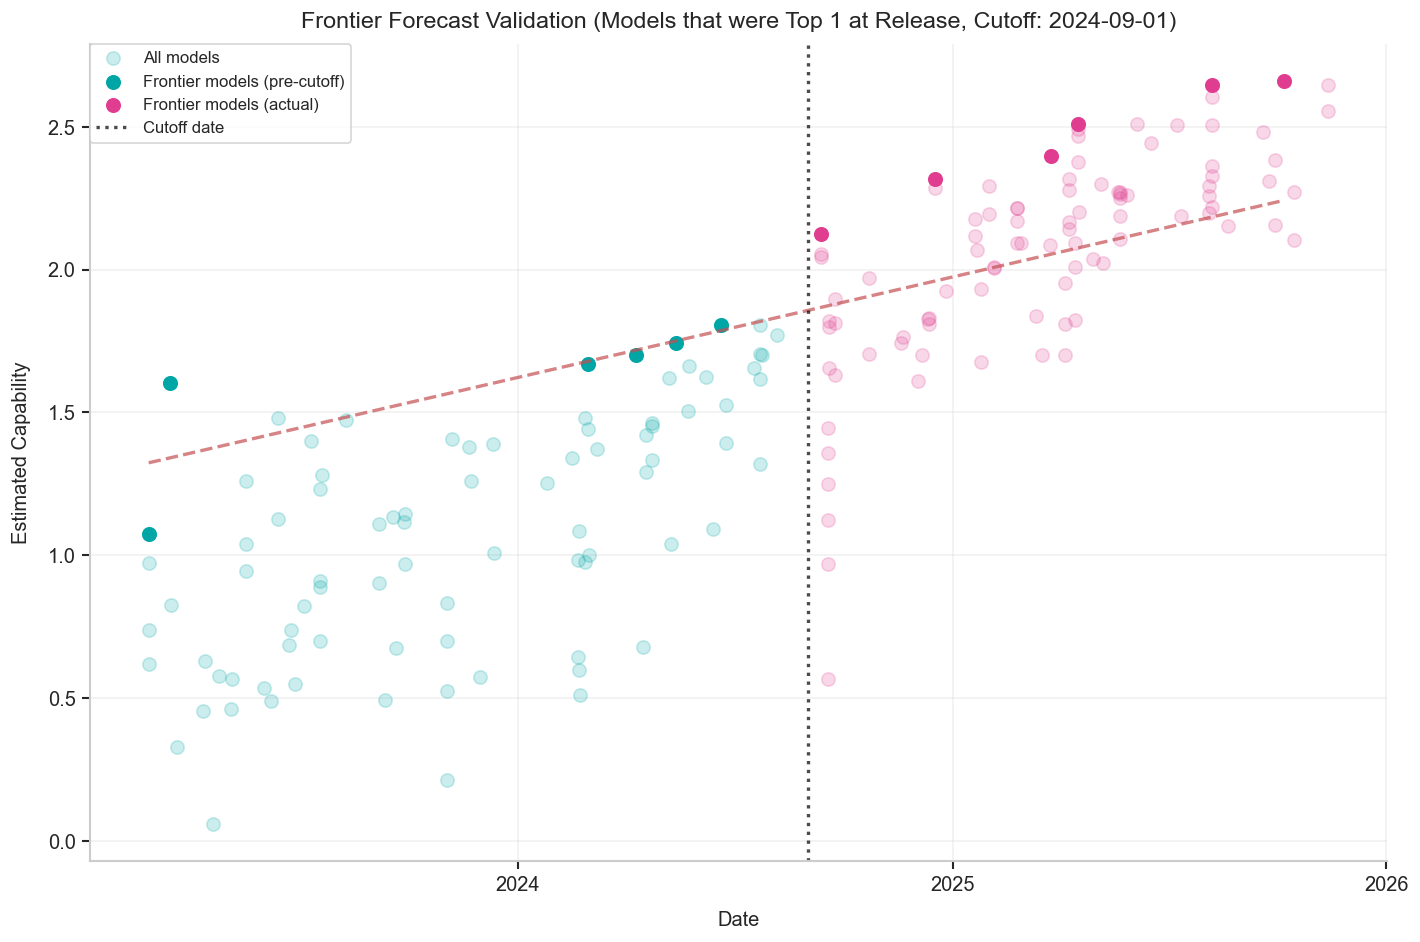

In [14]:
def validate_forecast_accuracy(df_capabilities: pd.DataFrame, 
                             cutoff_date: str,
                             top_n_models: int,
                             label_frontier: bool = False):
    """Validate forecast accuracy by comparing pre-cutoff predictions to post-cutoff reality"""
    print(f"Validating forecast accuracy with cutoff date: {cutoff_date} using models that were top {top_n_models} at release")
    
    df = prepare_model_data(df_capabilities)
    cutoff_dt = pd.to_datetime(cutoff_date)
    
    # Get all data for context plots
    pre_cutoff_all = filter_by_date(df, 'date_obj', cutoff_date, before=True)
    post_cutoff_all = filter_by_date(df, 'date_obj', cutoff_date, before=False)
    
    # Identify frontier models using the same logic as create_future_forecast
    # But only use pre-cutoff data for training
    frontier_models_pre = []
    frontier_models_post = []
    
    for _, model in df.iterrows():
        model_release_date = model['date_obj']
        
        # Find all models that existed at or before this model's release date
        available_models = df[df['date_obj'] <= model_release_date]
        
        # Check if this model was among the top N at its release time
        top_models_at_release = available_models.nlargest(top_n_models, 'estimated_capability')
        
        if model['model'] in top_models_at_release['model'].values:
            if model_release_date <= cutoff_dt:
                frontier_models_pre.append(model)
            else:
                frontier_models_post.append(model)
    
    pre_cutoff = pd.DataFrame(frontier_models_pre)
    post_cutoff = pd.DataFrame(frontier_models_post)
    
    if len(pre_cutoff) == 0 or len(post_cutoff) == 0:
        print("Insufficient data for validation - skipping accuracy analysis")
        return {}
    
    # Fit model on pre-cutoff data
    X_pre = (pre_cutoff['date_obj'] - pre_cutoff['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y_pre = pre_cutoff['estimated_capability'].values
    
    model = LinearRegression()
    model.fit(X_pre, y_pre)
    
    # Make predictions for post-cutoff dates
    X_post = (post_cutoff['date_obj'] - pre_cutoff['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y_pred = model.predict(X_post)
    y_actual = post_cutoff['estimated_capability'].values
    
    # Calculate accuracy metrics
    mae = np.mean(np.abs(y_pred - y_actual))
    rmse = np.sqrt(np.mean((y_pred - y_actual)**2))
    r2 = 1 - np.sum((y_actual - y_pred)**2) / np.sum((y_actual - np.mean(y_actual))**2)
    
    # Create validation plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot all models (faded) for context
    ax.scatter(pre_cutoff_all['date_obj'], pre_cutoff_all['estimated_capability'], 
              alpha=0.2, s=64, label='All models', color=colors[0])
    ax.scatter(post_cutoff_all['date_obj'], post_cutoff_all['estimated_capability'], 
              alpha=0.2, s=64, color=colors[1])
    
    # Plot frontier models
    ax.scatter(pre_cutoff['date_obj'], pre_cutoff['estimated_capability'], 
              alpha=1, s=64, label=f'Frontier models (pre-cutoff)', color=colors[0])
    
    ax.scatter(post_cutoff['date_obj'], post_cutoff['estimated_capability'], 
              alpha=1, s=64, label=f'Frontier models (actual)', color=colors[1])

    # Optional labels for frontier models
    if label_frontier:
        for _, r in pre_cutoff.dropna(subset=['date_obj', 'estimated_capability']).iterrows():
            ax.annotate(
                r['model'],
                xy=(r['date_obj'], r['estimated_capability']),
                xytext=(4, 4),
                textcoords='offset points',
                fontsize=8,
                color=colors[0],
                alpha=0.9,
            )
        for _, r in post_cutoff.dropna(subset=['date_obj', 'estimated_capability']).iterrows():
            ax.annotate(
                r['model'],
                xy=(r['date_obj'], r['estimated_capability']),
                xytext=(4, 4),
                textcoords='offset points',
                fontsize=8,
                color=colors[1],
                alpha=0.9,
            )
    
    # Plot predictions
    # ax.scatter(post_cutoff['date_obj'], y_pred, 
    #           alpha=0.7, s=50, marker='x', label='Predicted', color='red')
    
    # Plot trend line
    all_dates = pd.concat([pre_cutoff['date_obj'], post_cutoff['date_obj']])
    X_all = (all_dates - pre_cutoff['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y_trend = model.predict(X_all)
    ax.plot(all_dates, y_trend, 'r--', alpha=0.7)
    
    # Add cutoff line
    ax.axvline(x=cutoff_dt, color='black', linestyle=':', alpha=0.7, label='Cutoff date')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(f'Frontier Forecast Validation (Models that were Top {top_n_models} at Release, Cutoff: {cutoff_date})')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(f"outputs/notebooks/frontier_forecast_validation.pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"outputs/notebooks/frontier_forecast_validation.svg", format="svg")
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'n_training': len(pre_cutoff),
        'n_validation': len(post_cutoff),
        'slope': model.coef_[0] * 365.25,  # Convert to per-year
        'intercept': model.intercept_
    }


# Validate forecast accuracy using df_cm1 (full dataset)
validation_results = validate_forecast_accuracy(
    df_cm1, 
    CUTOFF_DATE, 
    TOP_N_MODELS, 
    label_frontier=LABEL_FRONTIER
)
# plt.savefig('outputs/figures/figure-6.svg', format='svg')
plt.savefig("outputs/forecasting/frontier_forecast_validation.pdf")
plt.savefig("outputs/forecasting/frontier_forecast_validation.svg", format="svg")

if validation_results:
    print(f"\nValidation Results (cutoff: {CUTOFF_DATE}):")
    print(f"  MAE: {validation_results['mae']:.3f}")
    print(f"  RMSE: {validation_results['rmse']:.3f}")
    print(f"  R²: {validation_results['r2']:.3f}")
    print(f"  Annual growth rate: {validation_results['slope']:.3f}")
    print(f"  Training points: {validation_results['n_training']}")
    print(f"  Validation points: {validation_results['n_validation']}")


# Figure 9: Acceleration Detection (Section 3.2.1 Forecasting future capabilities and Appendix E.5.1)


In [15]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def piecewise_linear(x, slope1, intercept1, slope2, breakpoint):
    """Piecewise linear function with continuity at breakpoint"""
    intercept2 = slope1 * breakpoint + intercept1 - slope2 * breakpoint
    return np.where(x < breakpoint, slope1*x + intercept1, slope2*x + intercept2)

def fit_piecewise_linear(x, y, num_breaks=30):
    """Fit a piecewise linear model by scanning candidate breakpoints"""
    best = (-np.inf, None)
    xs, ys = x, y
    rng = xs.max() - xs.min()
    min_bp = xs.min() + 0.1 * rng
    max_bp = xs.max() - 0.1 * rng
    lower = [-np.inf, -np.inf, -np.inf, min_bp]
    upper = [ np.inf,  np.inf,  np.inf, max_bp]

    for bp in np.linspace(min_bp, max_bp, num_breaks):
        left = xs <= bp
        right = xs > bp
        if left.sum() < 2 or right.sum() < 2:
            continue

        # Initial guesses
        m1, b1 = np.polyfit(xs[left], ys[left], 1)
        m2, _  = np.polyfit(xs[right], ys[right], 1)
        i1 = np.mean(ys[left]) - m1 * np.mean(xs[left])
        p0 = [m1, i1, m2, bp]

        try:
            params, _ = curve_fit(
                piecewise_linear,
                xs, ys,
                p0=p0,
                bounds=(lower, upper),
                maxfev=2000
            )
            r2 = r2_score(ys, piecewise_linear(xs, *params))
            if r2 > best[0]:
                best = (r2, params)
        except Exception:
            pass

    return best[1], best[0]

def detect_acceleration_frontier(df_capabilities: pd.DataFrame, 
                                 num_breaks: int = 50,
                                 min_slope_ratio: float = 1.5):
    """
    Detect acceleration in frontier model capabilities using piecewise linear fitting.
    
    Args:
        df_capabilities: DataFrame with 'date' and 'estimated_capability' columns
        num_breaks: Number of candidate breakpoints to try
        min_slope_ratio: Minimum slope ratio to consider as acceleration
    
    Returns:
        Dictionary with detection results
    """
    df = prepare_model_data(df_capabilities)
    
    # Compute running maximum (frontier)
    df = df.sort_values('date_obj')
    df['running_max'] = df['estimated_capability'].cummax()
    
    # # Get frontier models (those that set new records)
    # frontier_df = df[df['estimated_capability'] == df['running_max']].copy()
    frontier_df = (
        df[df['estimated_capability'] == df['running_max']]
        .sort_values(['date_obj', 'estimated_capability'])
        .drop_duplicates(subset='date_obj', keep='last')
    )
    
    if len(frontier_df) < 10:
        print("Insufficient frontier data points for acceleration detection")
        return {}
    
    # Convert dates to years (numeric)
    x = mdates.date2num(frontier_df['date_obj'].values)
    y = frontier_df['estimated_capability'].values
    
    # Fit piecewise linear model
    params, r2 = fit_piecewise_linear(x, y, num_breaks=num_breaks)
    
    if params is None:
        print("Failed to fit piecewise linear model")
        return {}
    
    slope1, intercept1, slope2, bp = params
    
    # Convert breakpoint back to date (remove timezone to avoid comparison issues)
    breakpoint_date = mdates.num2date(bp).replace(tzinfo=None)
    
    # Calculate slope ratio
    slope_ratio = slope2 / slope1 if slope1 > 0 else np.inf
    
    # Check if acceleration detected
    acceleration_detected = slope_ratio >= min_slope_ratio
    
    # Visualize
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # All models (faded)
    ax.scatter(df['date_obj'], df['estimated_capability'],
              alpha=0.2, s=64, label='All models', color=colors[0], edgecolor='white', linewidths=0.5)
    
    # Frontier models
    ax.scatter(frontier_df['date_obj'], frontier_df['estimated_capability'],
              s=64, label='Frontier (running max)', color=colors[0], alpha=1, edgecolor='white', linewidths=0.5)
    
    # Piecewise fit
    x_fine = np.linspace(x.min(), x.max(), 400)
    y_fine = piecewise_linear(x_fine, *params)
    dates_fine = [mdates.num2date(d).replace(tzinfo=None) for d in x_fine]
    ax.plot(dates_fine, y_fine, '--', linewidth=2, label='Piecewise linear fit', color=colors[1])
    
    # Breakpoint line
    ax.axvline(x=breakpoint_date, color=colors[2], linestyle=':', linewidth=2, 
              label=f'Breakpoint: {breakpoint_date.strftime("%Y-%m-%d")}')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(f'Frontier Acceleration Detection\n' +
                f'Pre-break slope: {slope1*365.25:.3f}/year, Post-break slope: {slope2*365.25:.3f}/year, ' +
                f'Ratio: {slope_ratio:.2f}x (R²={r2:.4f})')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=0)
    plt.tight_layout()
    
    return {
        'breakpoint_date': breakpoint_date,
        'slope_pre': slope1,
        'slope_post': slope2,
        'slope_pre_per_year': slope1 * 365.25,
        'slope_post_per_year': slope2 * 365.25,
        'slope_ratio': slope_ratio,
        'r2': r2,
        'acceleration_detected': acceleration_detected,
        'frontier_df': frontier_df,
        'params': params
    }


Running acceleration detection on frontier models...

Saved acceleration detection plot to outputs/forecasting/real_data_acceleration_detection.svg


ACCELERATION DETECTION RESULTS
Breakpoint detected at: 2024-03-23
Pre-break slope: 0.352 capability units/year
Post-break slope: 0.689 capability units/year
Slope ratio: 1.95x
Model fit (R²): 0.9345
Acceleration detected: True

Comparison to known events:
  Days from ChatGPT release: 479 days
  Days from o1 release: -173 days

Frontier models around breakpoint (±6 months):


,model,date,estimated_capability
143,claude-3-opus-20240229,2024-02-29,1.669307
125,gpt-4-turbo-2024-04-09,2024-04-09,1.700284
154,gpt-4o-2024-05-13,2024-05-13,1.743907
153,claude-3-5-sonnet-20240620,2024-06-20,1.805797
130,o1-mini-2024-09-12_high,2024-09-12,2.126120


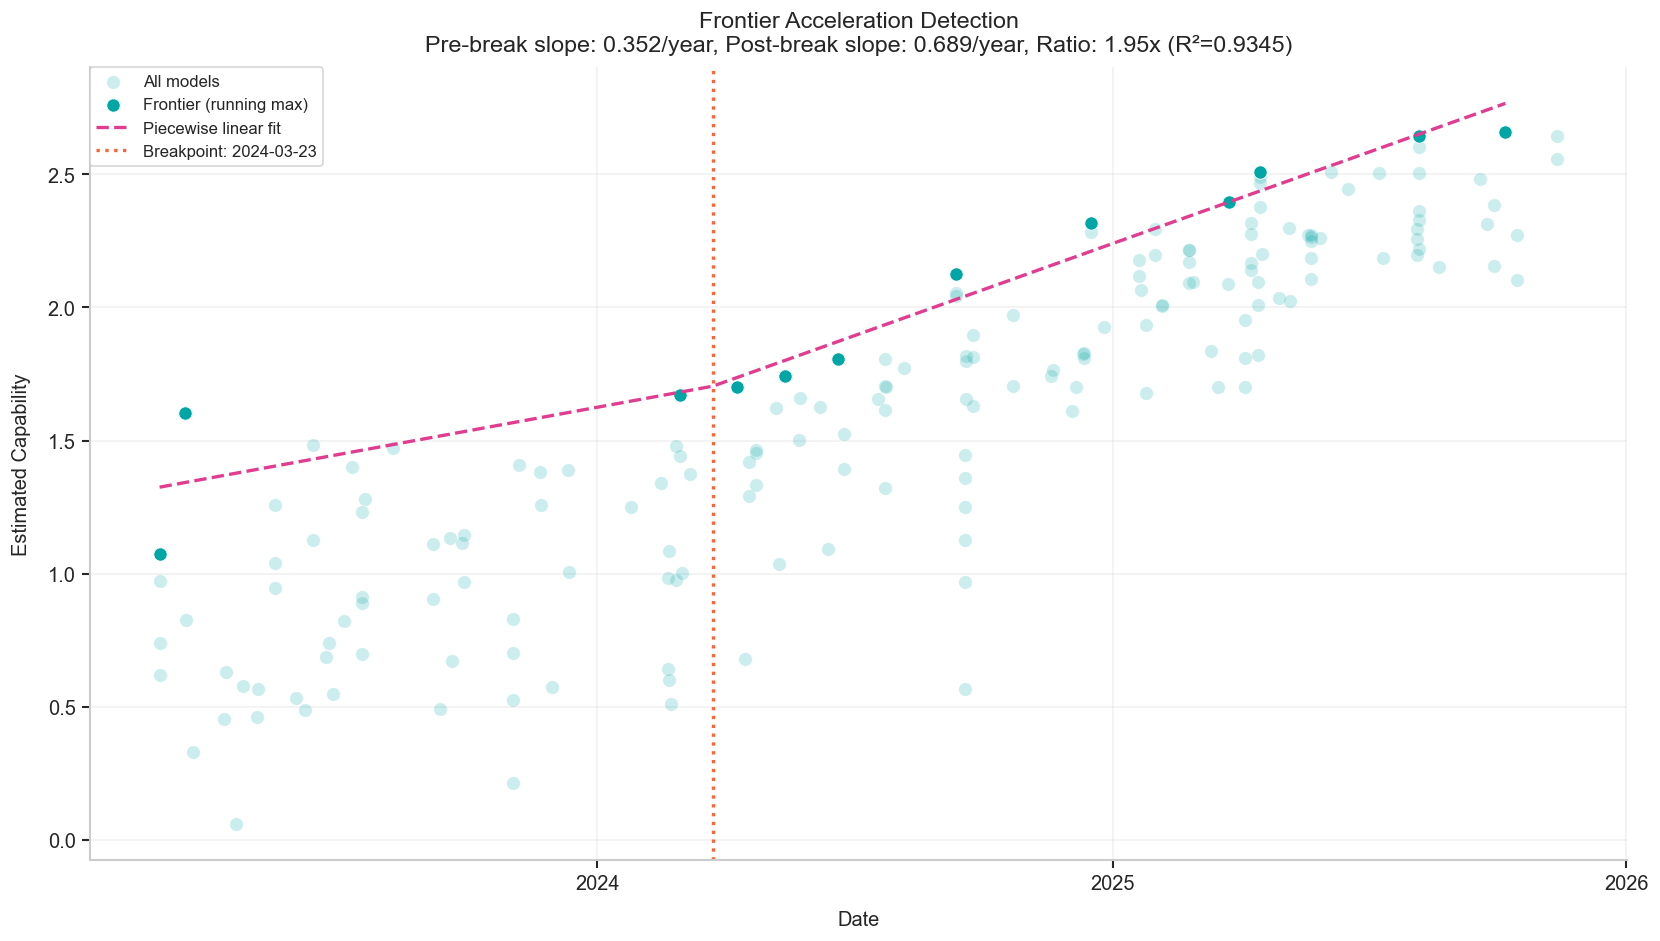

In [16]:
# Run acceleration detection on full dataset (df_cm1)
print("Running acceleration detection on frontier models...")
print("=" * 80)

accel_results = detect_acceleration_frontier(
    df_cm1,
    num_breaks=50,
    min_slope_ratio=1.5  # Detect if post-break is 1.5x faster than pre-break
)

# Save the acceleration detection plot
output_path = 'outputs/forecasting/real_data_acceleration_detection.svg'
plt.savefig(output_path, bbox_inches='tight', dpi=300)
# plt.savefig('outputs/figures/figure-9.svg', format='svg')

print(f"\nSaved acceleration detection plot to {output_path}\n")

if accel_results:
    print("\nACCELERATION DETECTION RESULTS")
    print("=" * 80)
    print(f"Breakpoint detected at: {accel_results['breakpoint_date'].strftime('%Y-%m-%d')}")
    print(f"Pre-break slope: {accel_results['slope_pre_per_year']:.3f} capability units/year")
    print(f"Post-break slope: {accel_results['slope_post_per_year']:.3f} capability units/year")
    print(f"Slope ratio: {accel_results['slope_ratio']:.2f}x")
    print(f"Model fit (R²): {accel_results['r2']:.4f}")
    print(f"Acceleration detected: {accel_results['acceleration_detected']}")
    
    # Compare to known events
    breakpoint = accel_results['breakpoint_date']
    chatgpt_date = pd.Timestamp('2022-11-30')
    o1_date = pd.Timestamp('2024-09-12')
    
    print(f"\nComparison to known events:")
    print(f"  Days from ChatGPT release: {(breakpoint - chatgpt_date).days} days")
    print(f"  Days from o1 release: {(breakpoint - o1_date).days} days")
    
    # Show frontier models around the breakpoint
    frontier_df = accel_results['frontier_df']
    bp_date = accel_results['breakpoint_date']
    window = pd.Timedelta(days=180)  # 6 months
    
    around_bp = frontier_df[
        (frontier_df['date_obj'] >= bp_date - window) &
        (frontier_df['date_obj'] <= bp_date + window)
    ][['model', 'date', 'estimated_capability']].sort_values('date')
    
    if len(around_bp) > 0:
        print(f"\nFrontier models around breakpoint (±6 months):")
        display(around_bp)


In [17]:
frontier_df

,model_id,estimated_capability,model,is_anchor,Model,date,date_obj,running_max
46,m143,1.075789,LLaMA-65B,False,LLaMA-65B,2023-02-24,2023-02-24,1.075789
146,m7,1.604362,gpt-4-0314,False,GPT-4,2023-03-14,2023-03-14,1.604362
143,m67,1.669307,claude-3-opus-20240229,False,Claude 3 Opus,2024-02-29,2024-02-29,1.669307
125,m50,1.700284,gpt-4-turbo-2024-04-09,False,GPT-4 Turbo,2024-04-09,2024-04-09,1.700284
154,m77,1.743907,gpt-4o-2024-05-13,False,GPT-4o,2024-05-13,2024-05-13,1.743907
153,m76,1.805797,claude-3-5-sonnet-20240620,False,Claude 3.5 Sonnet,2024-06-20,2024-06-20,1.805797
130,m55,2.126120,o1-mini-2024-09-12_high,False,o1-mini,2024-09-12,2024-09-12,2.126120
2,m100,2.315625,o1-2024-12-17_medium,False,o1,2024-12-17,2024-12-17,2.315625
117,m43,2.396804,gemini-2.5-pro-exp-03-25,False,Gemini 2.5 Pro,2025-03-25,2025-03-25,2.396804
107,m34,2.509142,o3-2025-04-16_high,False,o3,2025-04-16,2025-04-16,2.509142
